# Appointment Propensity and Attendance

## Propensity to miss appointments (DNA).

## Propensity for staff type.

## Propensity for appointment mode.

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

### **Importing libraries**

In [1]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package

from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# project imports from src
from src.schemas import DataCatalog
from src.various_methods import PlotCounter
import src.constants as constants

### **Loading the catalog**

In [2]:
# Loading the Data Catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

# Initializing the plotCounter object
plot_counter = PlotCounter(name='appointment_attendance')

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [3]:
# find the entry
gp_appts_catalog_entry = catalog.get_catalog_entry_by_name('NHS GP Appointments by Region')

# load the snee data as dataframe
gp_appts_df = gp_appts_catalog_entry.load()

# Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

# join all the dataframes together
combined_df = pd.concat(dfs, axis=0)
combined_df.head()

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,8 to 14 Days,1101


#### **Data pre-processing**
1. Removing un-necessary columns and making a copy  
   
2. Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2023 only from april to august)**

In [4]:
def convert_to_fy(timestamp: pd.Timestamp) -> int:
    """
    Converts a given timestamp to the corresponding fiscal year.

    Args:
        timestamp (pd.Timestamp): The timestamp to convert.

    Returns:
        int: The fiscal year corresponding to the given timestamp.
    """

    if timestamp.month >= 4:
        return timestamp.year
    else:
        return timestamp.year - 1


## Staff appointment propensity

### In each area, for the FY 2022 & 2023, what is the tendancy in each area for to use each healthcare professional?

In [5]:
# Appointment propensity by region
staff_appointments_df = (
    combined_df.copy() # copy the dataframe
    .assign(FY=lambda df: pd.to_datetime(df['APPOINTMENT_MONTH'],  format="%b%Y") # convert to datetime
            .map(convert_to_fy) # convert to fiscal year
            )
    )

# find the number of appointments for each sub-icb for each year
all_appointments_df = staff_appointments_df.groupby(['FY', 'SUB_ICB_LOCATION_CODE'])[['COUNT_OF_APPOINTMENTS']].sum()

# find the number of appointments for each sub-icb for each year
staff_appointments_df = staff_appointments_df.groupby(['FY', 'SUB_ICB_LOCATION_CODE','HCP_TYPE'])[['COUNT_OF_APPOINTMENTS']].sum()

# join the two dataframes together, using the index
staff_propensity_df = all_appointments_df.join(staff_appointments_df, how='left', lsuffix='_total', rsuffix='_staff')

# define the propensity as the number of staff appointments divided by the total number of appointments
staff_propensity_df['propensity'] = (staff_propensity_df['COUNT_OF_APPOINTMENTS_staff'] / staff_propensity_df['COUNT_OF_APPOINTMENTS_total']).round(4)

# reset the index
staff_propensity_df = staff_propensity_df.reset_index()

# define an empty-ish dictionary with default value of 0.0
staff_propensity_dict = {k:{k2:0.0 for k2 in staff_propensity_df['HCP_TYPE'].unique()} for k in staff_propensity_df['SUB_ICB_LOCATION_CODE'].unique()}

# get the 2023 data only
staff_propensity_2023_df = staff_propensity_df[staff_propensity_df['FY']>=2022]

# write to dictionary, horrible iteration but easier to do than something else
for _, row in staff_propensity_2023_df.iterrows():
    staff_propensity_dict[row['SUB_ICB_LOCATION_CODE']][row['HCP_TYPE']] = row['propensity']

# dump to yaml file
yaml.dump(staff_propensity_dict, open('outputs/staff_propensity.yaml', 'w'))

del staff_propensity_df, staff_propensity_2023_df, staff_propensity_dict, all_appointments_df, staff_appointments_df

## Appointment mode propensity

### For each staff type, in each area, what is the propensity for the patient to choose each appointment type?



In [6]:
# Appointment propensity by region
method_propensity_df = (
    combined_df.copy() # copy the dataframe
    .assign(FY=lambda df: pd.to_datetime(df['APPOINTMENT_MONTH'],  format="%b%Y") # convert to datetime
            .map(convert_to_fy) # convert to fiscal year
            )
    )

# find the number of appointments for each sub-icb for each year
all_appointments_df = method_propensity_df.groupby(['FY', 'SUB_ICB_LOCATION_CODE','HCP_TYPE'])[['COUNT_OF_APPOINTMENTS']].sum()

# find the number of appointments for each sub-icb for each year
method_propensity_df = method_propensity_df.groupby(['FY', 'SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE'])[['COUNT_OF_APPOINTMENTS']].sum()

# join the two dataframes together, using the index
method_propensity_df = all_appointments_df.join(method_propensity_df, how='left', lsuffix='_total', rsuffix='_mode')

# define the propensity as the number of staff appointments divided by the total number of appointments
method_propensity_df['propensity'] = (method_propensity_df['COUNT_OF_APPOINTMENTS_mode'] / method_propensity_df['COUNT_OF_APPOINTMENTS_total']).round(4)

# reset the index
method_propensity_df = method_propensity_df.reset_index()

# define an empty-ish dictionary with default value of 0.0
method_propensity_dict = {k:
                         {k2:
                          {k3: 0.0 for k3 in method_propensity_df['APPT_MODE'] } 
                          for k2 in method_propensity_df['HCP_TYPE'].unique()} 
                          for k in method_propensity_df['SUB_ICB_LOCATION_CODE'].unique()}

# get the 2023 data only
method_propensity_2023_df = method_propensity_df[method_propensity_df['FY']>=2022]

# write to dictionary, horrible iteration but easier to do than something else
for _, row in method_propensity_2023_df.iterrows():
    method_propensity_dict[row['SUB_ICB_LOCATION_CODE']][row['HCP_TYPE']][row['APPT_MODE']] = row['propensity']

# dump to yaml file
yaml.dump(method_propensity_dict, open('outputs/appt_mode_propensity.yaml', 'w'))

### Propensity Plots

In [7]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']
combined_df_copy = combined_df[needed_cols].copy()

combined_df_copy['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH'], format="%b%Y").dt.to_period('M')
    
combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021']
combined_df_copy['APPOINTMENT_MONTH'].unique()

<PeriodArray>
['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
 '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05',
 '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
 '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
 '2023-08']
Length: 29, dtype: period[M]

## **Analysis using mean of appointments**

### **Creating separate DF's for Attend and DNA appointments based on FY-YEARS**

In [8]:
# Dataframe for appointments attended
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
attended_df['FY_YEAR'] = attended_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments attended
attended_df_mean = attended_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
attended_df_mean['COUNT_OF_APPOINTMENTS'] = attended_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
attended_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021               441761.8
                                                   FY2022               459362.6
                                                   FY2023               448728.0
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021               403123.0
                                                   FY2022               413585.7

2023 ka average match islie nahe ho raha hai kyunki divide 12 se nahe balki 5 se ho raha hai kyunki data me august/23 tak ka data ha FY23 k lie

In [9]:
# Dataframe for appointments DNA
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
do_not_attend_df['FY_YEAR'] = do_not_attend_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
dna_df_mean = do_not_attend_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
dna_df_mean['COUNT_OF_APPOINTMENTS'] = dna_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
dna_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021                14708.5
                                                   FY2022                16003.8
                                                   FY2023                14901.6
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                15846.7
                                                   FY2022                19536.8

In [10]:
# Dataframe for appointments DNA
unknown_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Unknown'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
unknown_df['FY_YEAR'] = unknown_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
unknown_df_mean = unknown_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
unknown_df_mean['COUNT_OF_APPOINTMENTS'] = unknown_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)
unknown_df_mean.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                      
NHS Bath and North East Somerset, Swindon and W... FY2021                19113.1
                                                   FY2022                16197.5
                                                   FY2023                27418.2
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                14403.2
                                                   FY2022                16174.3

### **Comparing the National average with SNEE**

#### **1. Attended appointments**

In [11]:
# Convert the 'count_column' to numeric
attended_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(attended_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_attended_2021 = attended_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_attended_2022 = attended_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_attended_2023_april_august = attended_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_attended = attended_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_attended_2021.item()} is the National average for attended appointments(FY-2021)')
print(f'{National_average_attended_2022.item()} is the National average for attended appointments(FY-2022)')
print(f'{National_average_attended_2023_april_august.item()} is the National average for attended appointments(FY-2023, april-august)')

SNEE_average_attended

579332.27 is the National average for attended appointments(FY-2021)
608099.22 is the National average for attended appointments(FY-2022)
591085.91 is the National average for attended appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,450111.8
FY2022,465021.9
FY2023,448269.2


#### **2. Not attended (DNA) Appointments**

In [12]:
# Convert the 'count_column' to numeric
dna_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(dna_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_dna_2021 = dna_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_dna_2022 = dna_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_dna_2023_april_august = dna_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_DNA = dna_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_dna_2021.item()} is the National average for DNA appointments(FY-2021)')
print(f'{National_average_dna_2022.item()} is the National average for DNA appointments(FY-2022)')
print(f'{National_average_dna_2023_april_august.item()} is the National average for DNA appointments(FY-2023, april-august)')

SNEE_average_DNA

27252.8 is the National average for DNA appointments(FY-2021)
31568.7 is the National average for DNA appointments(FY-2022)
29004.74 is the National average for DNA appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,16323.2
FY2022,17822.6
FY2023,14968.0


#### **3. Unknown Appointments**

In [13]:
# Convert the 'count_column' to numeric
unknown_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(unknown_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_unknown_2021 = unknown_df_mean.loc[slice(None),'FY2021',:].mean().round(2)
National_average_unknown_2022 = unknown_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_unknown_2023_april_august = unknown_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_average_unknown = unknown_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_unknown_2021.item()} is the National average for Unknown appointments(FY-2021)')
print(f'{National_average_unknown_2022.item()} is the National average for Unknown appointments(FY-2022)')
print(f'{National_average_unknown_2023_april_august.item()} is the National average for Unknown appointments(FY-2023, april-august)')

SNEE_average_unknown

25638.21 is the National average for Unknown appointments(FY-2021)
27095.84 is the National average for Unknown appointments(FY-2022)
33054.93 is the National average for Unknown appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,15382.2
FY2022,16936.3
FY2023,23803.0


### **Plotting the mean appointments for attended and non-attended based on FY-Years**

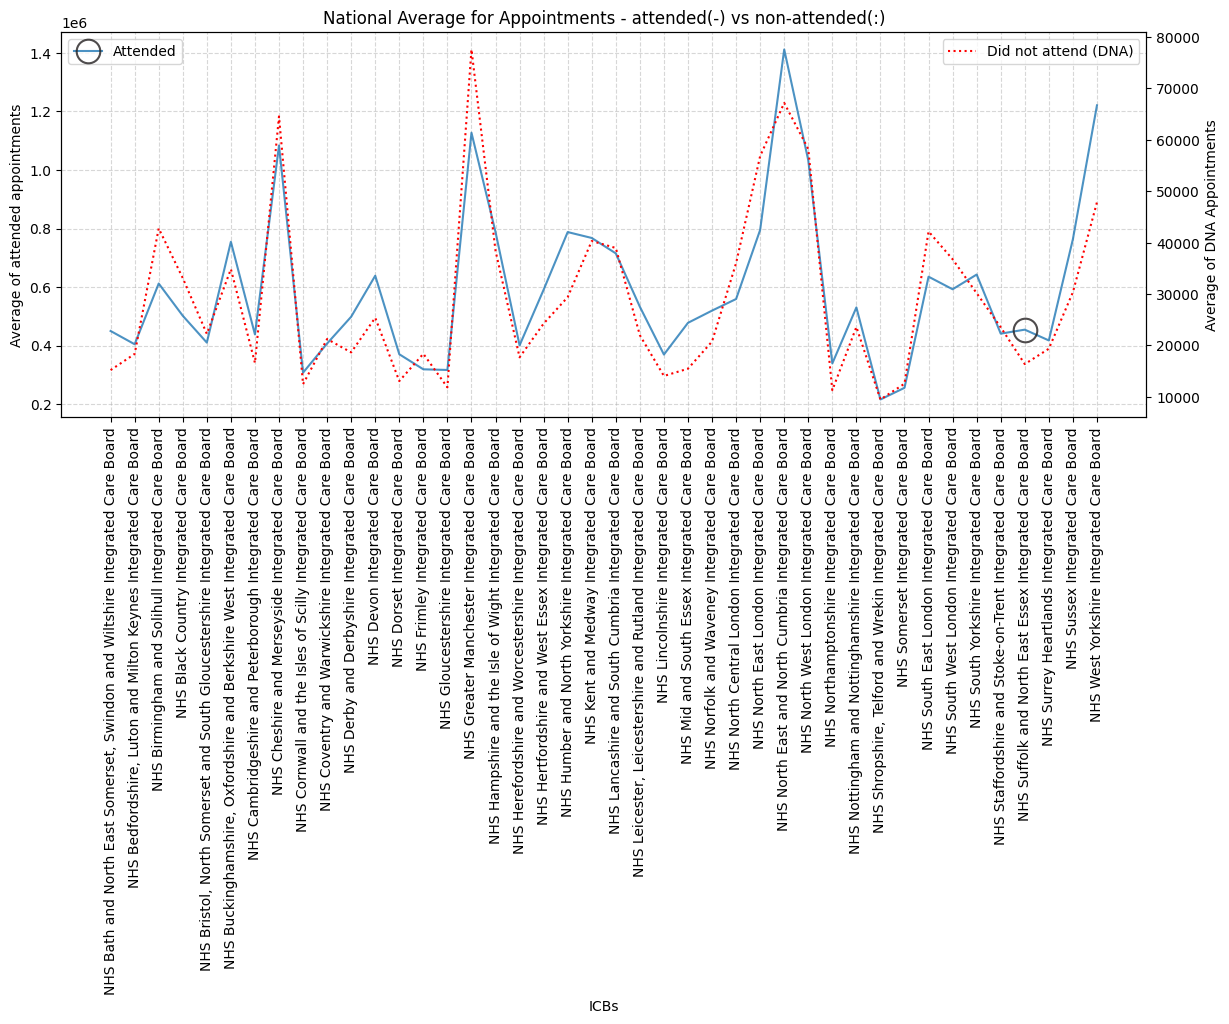

In [14]:
attended_df_mean2 = attended_df_mean.groupby('ICB_NAME').mean().reset_index()
dna_df_mean2 = dna_df_mean.groupby('ICB_NAME').mean().reset_index()
snee = 'NHS Suffolk and North East Essex Integrated Care Board'

# Plotting attended vs dna for FY-2021-22-23
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df_mean2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(0.6,30000), xytext=(36,60000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc = 'upper left')

# Creating secondary y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Average of DNA Appointments')
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean2, color ='red', linestyle=':', ax=ax2, label ='Did not attend (DNA)')

plt.savefig(f'{plot_counter.plot_name}.png', dpi=300, bbox_inches='tight')

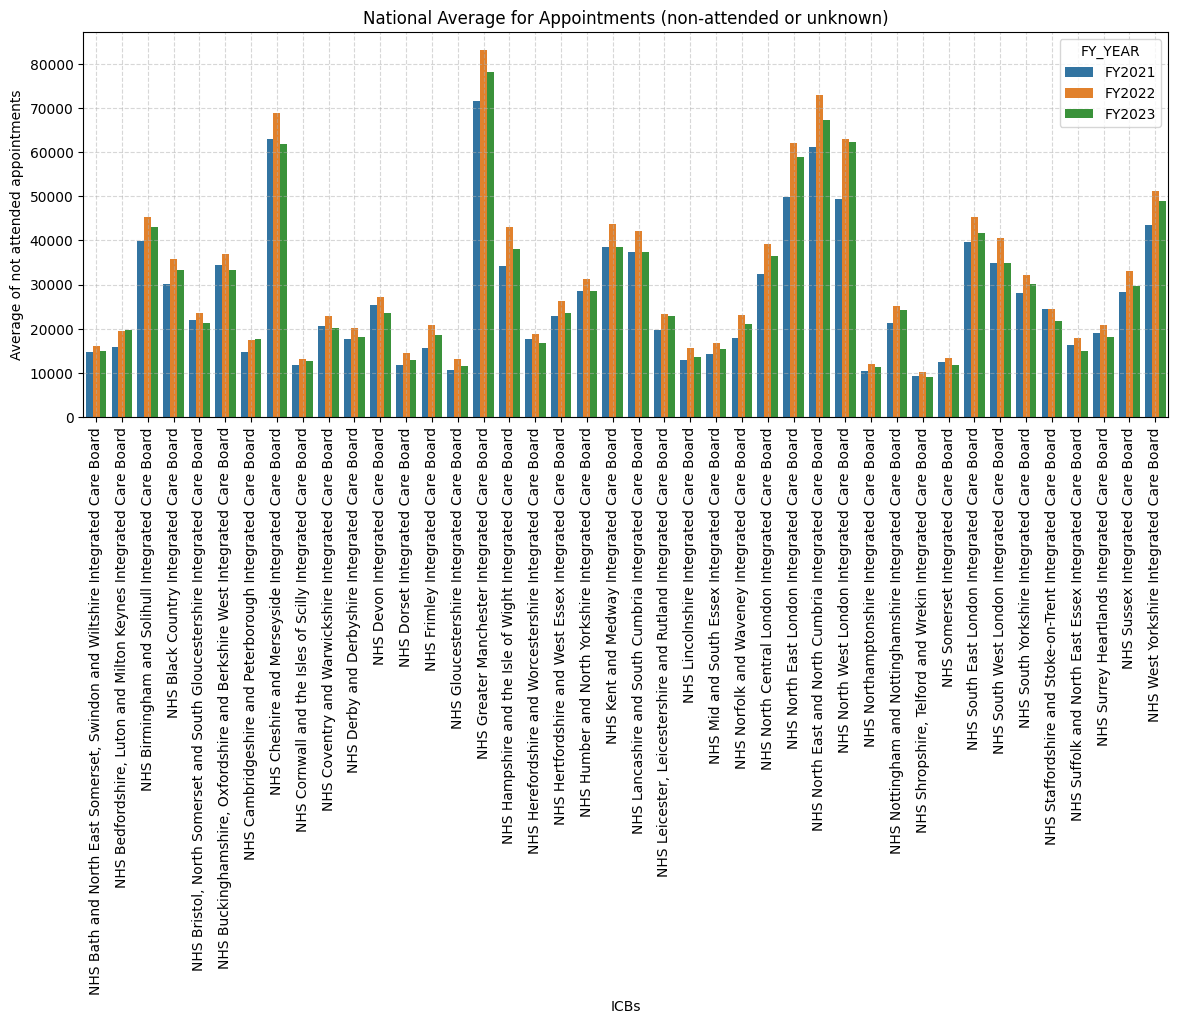

In [15]:
# Plotting the did not attended 
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.barplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.grid(True, linestyle='--', alpha=0.5)

### **Creating separate DF's for Attend and DNA appointments based on HCP-type and Appointment-mode**

In [16]:
combined_df_copy

,ICB_NAME,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,COUNT_OF_APPOINTMENTS
140,NHS West Yorkshire Integrated Care Board,02T,2021-04,Attended,GP,Face-to-Face,1598
141,NHS West Yorkshire Integrated Care Board,02T,2021-04,Attended,GP,Face-to-Face,405
142,NHS West Yorkshire Integrated Care Board,02T,2021-04,Attended,GP,Face-to-Face,3372
143,NHS West Yorkshire Integrated Care Board,02T,2021-04,Attended,GP,Face-to-Face,187
144,NHS West Yorkshire Integrated Care Board,02T,2021-04,Attended,GP,Face-to-Face,1215
...,...,...,...,...,...,...,...
5583,"NHS Bath and North East Somerset, Swindon and ...",92G,2023-08,Unknown,Unknown,Unknown,202
5584,"NHS Bath and North East Somerset, Swindon and ...",92G,2023-08,Unknown,Unknown,Unknown,153
5585,"NHS Bath and North East Somerset, Swindon and ...",92G,2023-08,Unknown,Unknown,Unknown,237
5586,"NHS Bath and North East Somerset, Swindon and ...",92G,2023-08,Unknown,Unknown,Unknown,40


In [17]:
# Dataframe for appointments attended
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','APPOINTMENT_MONTH']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)
attended_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face                3349381
                                                            Home Visit                    26843
                                                            Telephone                   2564097
                                                            Unknown                         841
                                                            Video/Online                  20199
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                   8565
                                                            Home Visit                     3256
                                                            Telephone                     64656
                                                            Unknown                     1029392
                                                            Video/Online                     85

[600 rows x 1 columns]

In [18]:
# Dataframe for appointments DNA
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','APPOINTMENT_MONTH']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)
dna_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE             APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP                   Face-to-Face                  80749
                                                                        Home Visit                      310
                                                                        Telephone                      9632
                                                                        Unknown                          46
                                                                        Video/Online                    313
...                                                                                                     ...
NHS West Yorkshire Integrated Care Board           Other Practice staff Video/Online                   6785
                                                   Unknown              Face-to-Face                      4
                                                                        Home Visit                       56
                                                                        Telephone                       855
                                                                        Unknown                       30403

[564 rows x 1 columns]

### **Plotting the mean DNA apointments based on HCP-TYPE and APPOINTMENT MODE**

In [19]:
# Calculating National average for GP's for DNA Appointments
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

# Calculating National average for Other Practice staff for DNA Appointments
DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

# Calculating National average for Unknown for DNA Appointments
DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
national_average_dna_hcp_appt_type

,GP,Practice staff,Unknown
Face to face,176980.1667,515303.2619,1469.8611
Home visit,1436.1190,2037.5238,1645.8333
Telephone,69502.7619,59696.1429,2549.5556
Unknown,2537.5854,5231.2143,11866.6452
Video/Online,1317.1667,3285.1190,2.6667


In [20]:
dna_hcptype_apptmode.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:]

COUNT_OF_APPOINTMENTS
HCP_TYPE             APPT_MODE                          
GP                   Face-to-Face                  68841
                     Home Visit                      590
                     Telephone                     16878
                     Unknown                          73
                     Video/Online                   1115
Other Practice staff Face-to-Face                 326987
                     Home Visit                     1568
                     Telephone                     17871
                     Unknown                         164
                     Video/Online                   5578
Unknown              Face-to-Face                  31603
                     Home Visit                      152
                     Telephone                        73
                     Unknown                       13097

<Axes: >

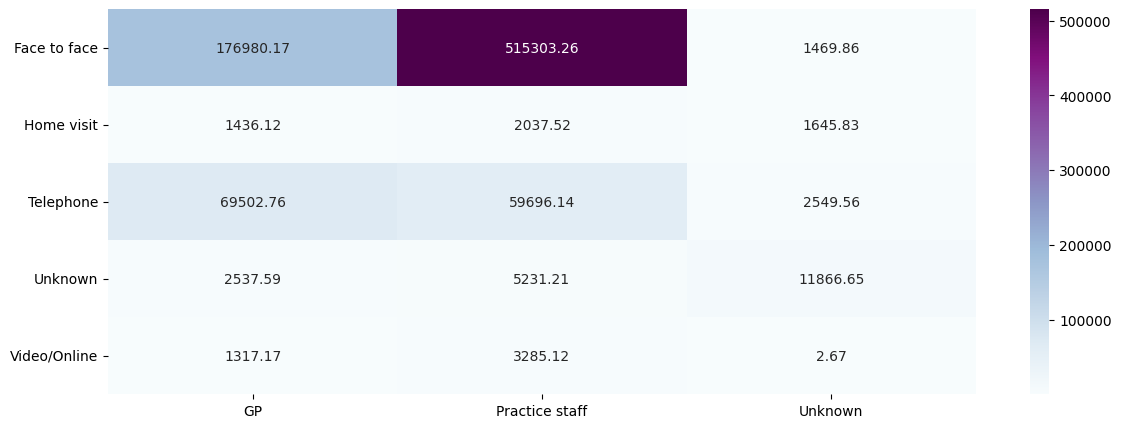

In [21]:
plt.subplots(figsize=(14,5))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='BuPu')

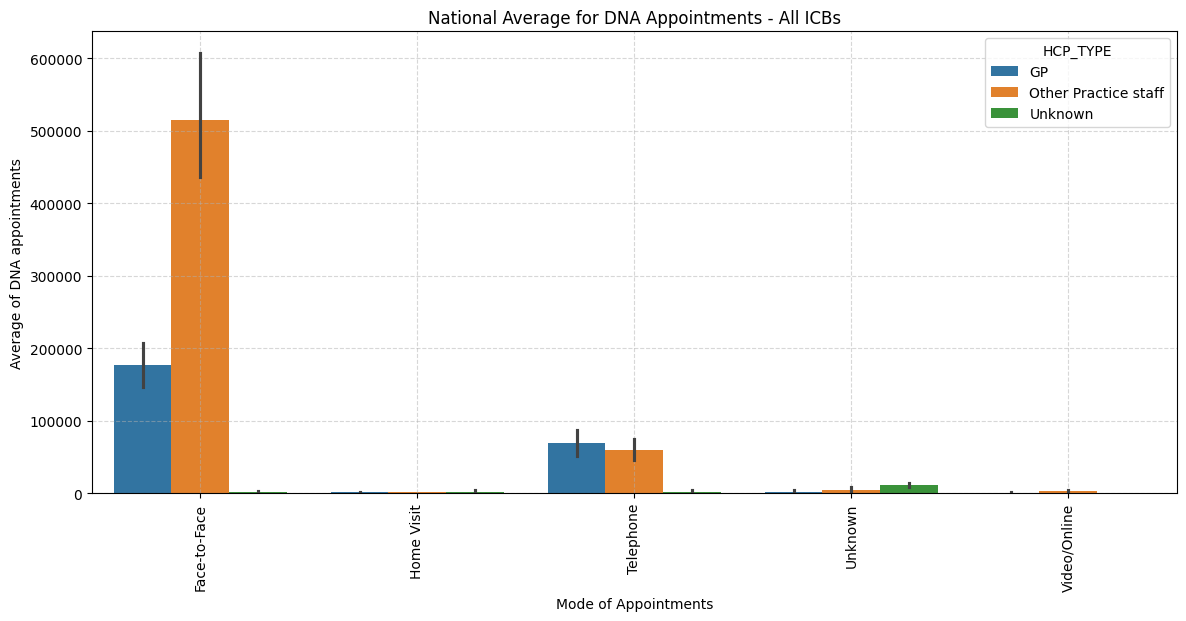

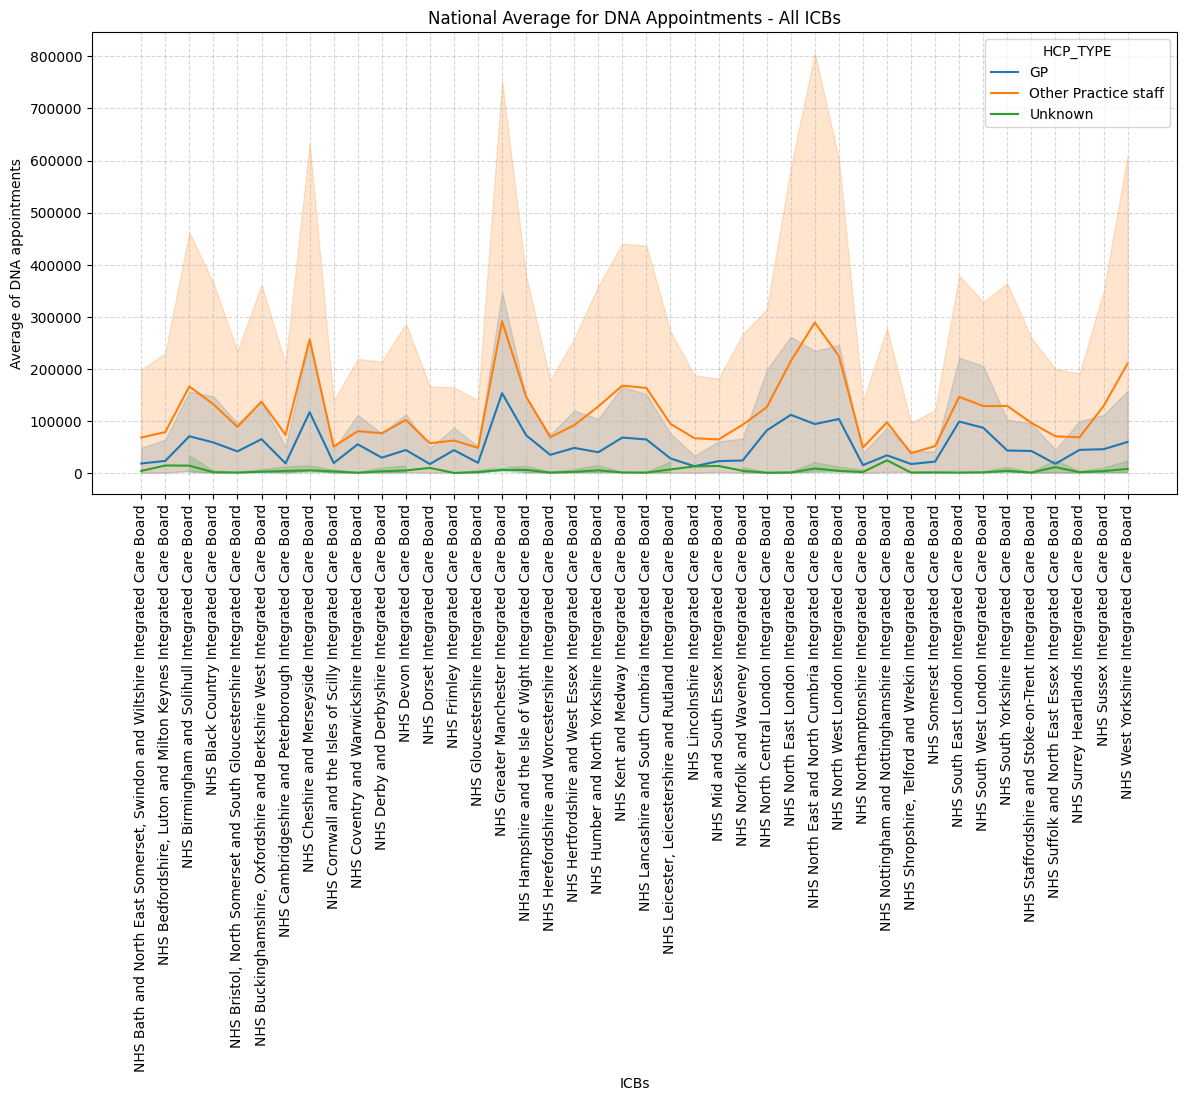

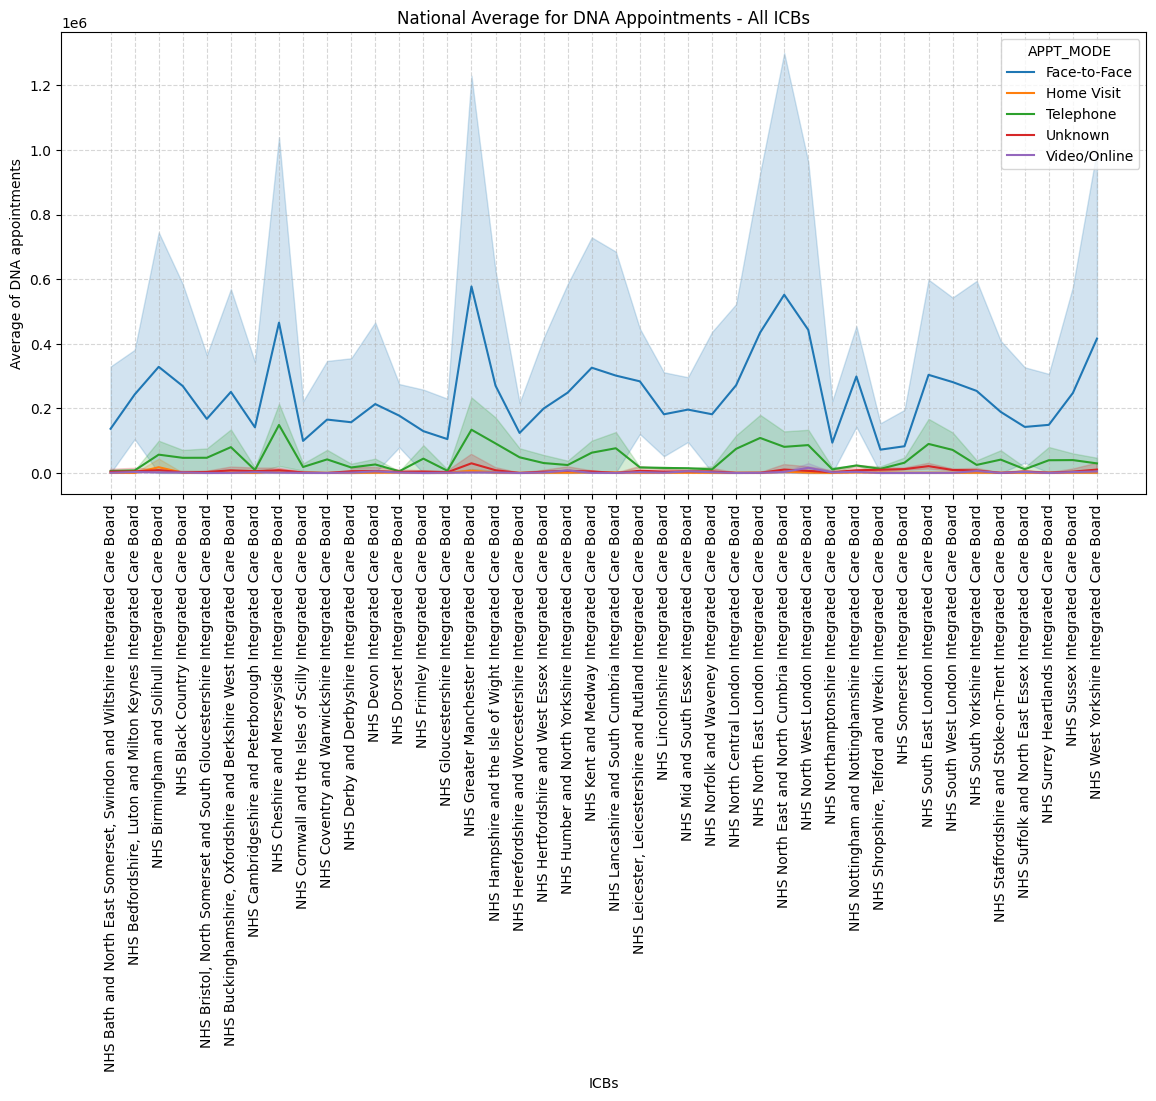

In [22]:
# Plotting the DNA appointments barplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('Mode of Appointments')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

## **Analysis using proportion(%) of appointments**

### **Proportion based on FY-YEARS**

In [23]:
appt_proportion = combined_df_copy.loc[:,['SUB_ICB_LOCATION_CODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','APPOINTMENT_MONTH']].pivot_table(index=['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion.sum(axis=1)
appt_proportion = appt_proportion.div(sum_row, axis=0)*100
appt_proportion = appt_proportion.reset_index()
appt_proportion.columns = ['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','Attended','DNA','Unknown']
appt_proportion.head()

,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,Attended,DNA,Unknown
0,00L,2021-04,95.432529,2.384112,2.183359
1,00L,2021-05,95.291121,2.364856,2.344023
2,00L,2021-06,94.833444,2.674138,2.492418
3,00L,2021-07,94.473248,2.890877,2.635876
4,00L,2021-08,94.899467,2.905211,2.195322


In [24]:
# Converting months into FY-years
appt_proportion['FY_YEAR'] = appt_proportion['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
appt_proportion_fy = appt_proportion.drop(columns=['APPOINTMENT_MONTH']).groupby(['SUB_ICB_LOCATION_CODE','FY_YEAR']).mean().round(2)
appt_proportion_fy.head()

Attended   DNA  Unknown
SUB_ICB_LOCATION_CODE FY_YEAR                         
00L                   FY2021      94.00  3.15     2.85
                      FY2022      93.08  3.69     3.23
                      FY2023      91.80  3.59     4.61
00N                   FY2021      92.00  4.06     3.93
                      FY2022      90.39  4.37     5.24

In [25]:
snee_sub_icb = ['06L','06T','07K']

National_proportion_2021 = appt_proportion_fy.loc[slice(None),'FY2021',:].mean().round(2)
National_proportion_2022 = appt_proportion_fy.loc[slice(None),'FY2022',:].mean().round(2)
National_proportion_2023_april_august = appt_proportion_fy.loc[slice(None),'FY2023',:].mean().round(2)
SNEE_sub_icb_proportion = appt_proportion_fy.loc[snee_sub_icb,:]


print(f'{National_proportion_2021} is the National PROPORTION for appointments(FY-2021)')
print(f'{National_proportion_2022} is the National PROPORTION for appointments(FY-2022)')
print(f'{National_proportion_2023_april_august} is the National PROPORTION for appointments(FY-2023, april-august)')

SNEE_sub_icb_proportion

Attended    91.56
DNA          4.26
Unknown      4.18
dtype: float64 is the National PROPORTION for appointments(FY-2021)
Attended    91.21
DNA          4.63
Unknown      4.17
dtype: float64 is the National PROPORTION for appointments(FY-2022)
Attended    90.55
DNA          4.35
Unknown      5.10
dtype: float64 is the National PROPORTION for appointments(FY-2023, april-august)


Attended   DNA  Unknown
SUB_ICB_LOCATION_CODE FY_YEAR                         
06L                   FY2021      94.44  2.40     3.16
                      FY2022      93.62  2.79     3.59
                      FY2023      91.95  2.70     5.35
06T                   FY2021      91.55  4.97     3.48
                      FY2022      91.16  4.91     3.92
                      FY2023      91.00  3.83     5.17
07K                   FY2021      94.66  2.58     2.76
                      FY2022      94.88  2.84     2.29
                      FY2023      93.56  2.62     3.82

In [26]:
SNEE_proportion = SNEE_sub_icb_proportion.reset_index().drop(columns=['SUB_ICB_LOCATION_CODE']).groupby(['FY_YEAR']).mean().round(2)
SNEE_proportion

,Attended,DNA,Unknown
FY_YEAR,,,
FY2021,93.55,3.32,3.13
FY2022,93.22,3.51,3.27
FY2023,92.17,3.05,4.78


### **Proportion based on HCP_TYPE and APPT_MODE**

In [27]:
appt_proportion_df = combined_df_copy.loc[:,['ICB_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS']].pivot_table(index=['ICB_NAME','HCP_TYPE','APPT_MODE'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df.sum(axis=1)
appt_proportion_df = appt_proportion_df.div(sum_row, axis=0)*100
appt_proportion_df_imputed = appt_proportion_df.fillna(appt_proportion_df.mean())
appt_proportion_df_imputed.head()

COUNT_OF_APPOINTMENTS  \
APPT_STATUS                                                                           Attended   
ICB_NAME                                           HCP_TYPE APPT_MODE                            
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face             95.067660   
                                                            Home Visit               97.536427   
                                                            Telephone                98.181941   
                                                            Unknown                  39.857820   
                                                            Video/Online             96.608954   

                                                                                    \
APPT_STATUS                                                                    DNA   
ICB_NAME                                           HCP_TYPE APPT_MODE                
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face  2.291951   
                                                            Home Visit    1.126413   
                                                            Telephone     0.368819   
                                                            Unknown       2.180095   
                                                            Video/Online  1.497035   

                                                                                     
APPT_STATUS                                                                 Unknown  
ICB_NAME                                           HCP_TYPE APPT_MODE                
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face   2.640389  
                                                            Home Visit     1.337161  
                                                            Telephone      1.449239  
                                                            Unknown       57.962085  
                                                            Video/Online   1.894012

In [28]:
# Calculating National average for HCP='GP' for Appointments
GP_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(2)
GP_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'GP','Home Visit'),:].mean().round(2)
GP_tel_ratio = appt_proportion_df_imputed.loc[:,'GP','Telephone'].mean().round(2)
GP_unknown_ratio = appt_proportion_df_imputed.loc[:,'GP','Unknown'].mean().round(2)
GP_video_online_ratio = appt_proportion_df_imputed.loc[:,'GP','Video/Online'].mean().round(2)

# Calculating National average for HCP='Other practice staff' for  Appointments
other_staff_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(2)
other_staff_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(2)
other_staff_tel_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Telephone'].mean().round(2)
other_staff_unknown_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Unknown'].mean().round(2)
other_staff_video_online_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Video/Online'].mean().round(2)

# Calculating National ratio for HCP='unknown' for Appointments
unknown_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(2)
unknown_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(2)
unknown_tel_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Telephone'].mean().round(2)
unknown_unknown_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Unknown'].mean().round(2)
unknown_video_online_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Video/Online'].mean().round(2)

In [29]:
res = {
    ('GP','Attended') : [GP_f2f_ratio.iloc[0], GP_homevisit_ratio.iloc[0], GP_tel_ratio.iloc[0], GP_unknown_ratio.iloc[0], GP_video_online_ratio.iloc[0]],
    ('GP','DNA') : [GP_f2f_ratio.iloc[1], GP_homevisit_ratio.iloc[1], GP_tel_ratio.iloc[1], GP_unknown_ratio.iloc[1], GP_video_online_ratio.iloc[1]],
    ('GP','Unknown') : [GP_f2f_ratio.iloc[2], GP_homevisit_ratio.iloc[2], GP_tel_ratio.iloc[2], GP_unknown_ratio.iloc[2], GP_video_online_ratio.iloc[2]],
    ('Other Staff','Attended') : [other_staff_f2f_ratio.iloc[0], other_staff_homevisit_ratio.iloc[0], other_staff_tel_ratio.iloc[0], other_staff_unknown_ratio.iloc[0], other_staff_video_online_ratio.iloc[0]],
    ('Other Staff','DNA') : [other_staff_f2f_ratio.iloc[1], other_staff_homevisit_ratio.iloc[1], other_staff_tel_ratio.iloc[1], other_staff_unknown_ratio.iloc[1], other_staff_video_online_ratio.iloc[1]],
    ('Other Staff','Unknown') : [other_staff_f2f_ratio.iloc[2], other_staff_homevisit_ratio.iloc[2], other_staff_tel_ratio.iloc[2], other_staff_unknown_ratio.iloc[2], other_staff_video_online_ratio.iloc[2]],
    ('Unknown','Attended') : [unknown_f2f_ratio.iloc[0], unknown_homevisit_ratio.iloc[0], unknown_tel_ratio.iloc[0], unknown_unknown_ratio.iloc[0], unknown_video_online_ratio.iloc[0]],
    ('Unknown','DNA') : [unknown_f2f_ratio.iloc[1], unknown_homevisit_ratio.iloc[1], unknown_tel_ratio.iloc[1], unknown_unknown_ratio.iloc[1], unknown_video_online_ratio.iloc[1]],
    ('Unknown','Unknown') : [unknown_f2f_ratio.iloc[2], unknown_homevisit_ratio.iloc[2], unknown_tel_ratio.iloc[2], unknown_unknown_ratio.iloc[2], unknown_video_online_ratio.iloc[2]]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_ratio_dna_hcp_appt_type = pd.DataFrame(res, index=index_values)
national_ratio_dna_hcp_appt_type

GP               Other Staff                Unknown        \
             Attended   DNA Unknown    Attended   DNA Unknown Attended   DNA   
Face to face    93.36  3.43    3.20       87.69  7.26    5.05    76.37  2.96   
Home visit      83.07  2.31   14.62       80.95  3.35   15.71    66.85  3.99   
Telephone       95.99  1.52    2.49       92.91  3.13    3.96    89.61  2.60   
Unknown         59.83  3.01   37.23       50.56  4.09   45.35    79.38  2.74   
Video/Online    91.13  1.46    7.40       86.81  3.72    9.48    81.71  3.77   

                      
             Unknown  
Face to face   23.00  
Home visit     31.43  
Telephone      10.56  
Unknown        30.33  
Video/Online   19.86

In [30]:
appt_proportion_df_imputed.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:].round(2)

COUNT_OF_APPOINTMENTS               
APPT_STATUS                                    Attended    DNA Unknown
HCP_TYPE             APPT_MODE                                        
GP                   Face-to-Face                 95.26   2.20    2.54
                     Home Visit                   93.53   1.78    4.69
                     Telephone                    97.81   0.68    1.51
                     Unknown                      44.41   2.79   52.79
                     Video/Online                 91.22   2.39    6.39
Other Practice staff Face-to-Face                 90.12   5.22    4.66
                     Home Visit                   88.89   3.58    7.53
                     Telephone                    95.89   1.19    2.91
                     Unknown                      34.29   2.37   63.34
                     Video/Online                 89.92   6.38    3.70
Unknown              Face-to-Face                 18.38  72.26    9.36
                     Home Visit                   87.96   0.93   11.12
                     Telephone                    91.25   3.13    5.62
                     Unknown                      92.12   2.30    5.58
                     Video/Online                100.00   3.28   17.16

## **Plots** 

In [31]:
appt_proportion_df_plots = combined_df_copy.pivot_table(index=['ICB_NAME','SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPOINTMENT_MONTH'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df_plots.sum(axis=1)
appt_proportion_df_plots = appt_proportion_df_plots.div(sum_row, axis=0)*100
appt_proportion_df_plots = appt_proportion_df_plots.reset_index().round(2)
appt_proportion_df_plots.columns = ['ICB_NAME','SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPOINTMENT_MONTH','Attended','DNA','Unknown']

# Converting months into FY-years
appt_proportion_df_plots['FY_YEAR'] = appt_proportion_df_plots['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")
appt_proportion_df_plots

,ICB_NAME,SUB_ICB_LOCATION_CODE,HCP_TYPE,APPT_MODE,APPOINTMENT_MONTH,Attended,DNA,Unknown,FY_YEAR
0,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-04,96.86,1.65,1.49,FY2021
1,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-05,96.73,1.36,1.91,FY2021
2,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-06,96.82,1.63,1.56,FY2021
3,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-07,96.52,1.77,1.71,FY2021
4,"NHS Bath and North East Somerset, Swindon and ...",92G,GP,Face-to-Face,2021-08,96.52,1.84,1.64,FY2021
...,...,...,...,...,...,...,...,...,...
35218,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-04,87.23,2.76,10.01,FY2023
35219,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-05,87.42,2.89,9.69,FY2023
35220,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-06,87.28,1.80,10.93,FY2023
35221,NHS West Yorkshire Integrated Care Board,X2C4Y,Unknown,Unknown,2023-07,90.17,2.10,7.73,FY2023


### **Attended Appointments** 

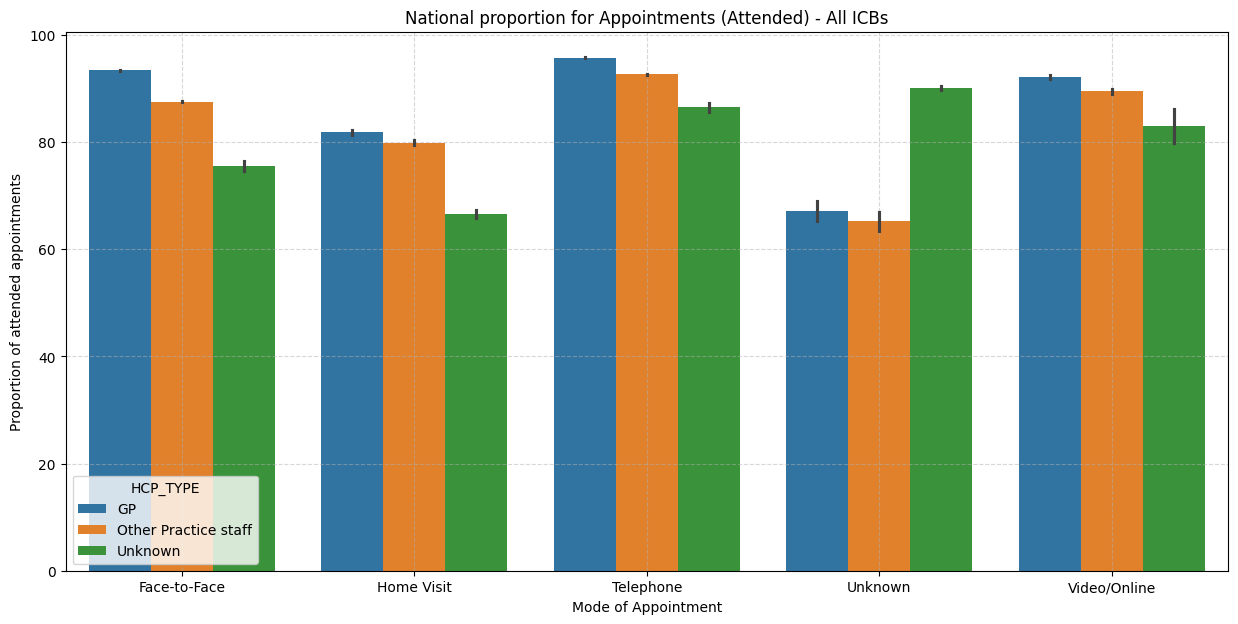

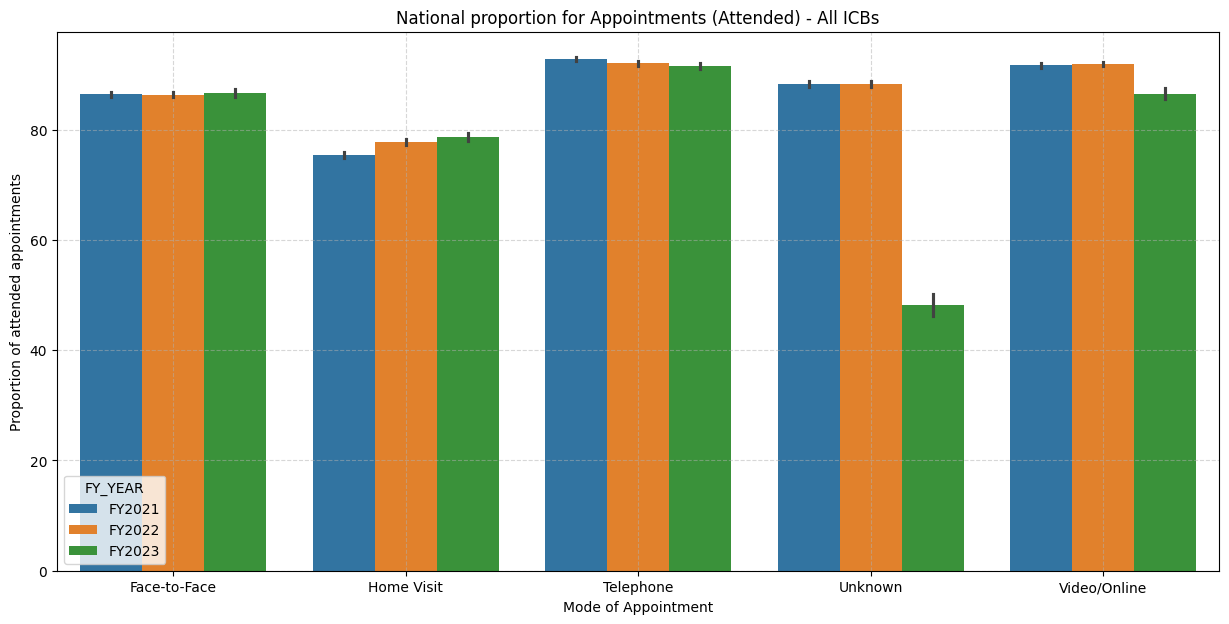

In [32]:
# Plotting the Attended appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the Attended appointments by FY Years
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

### **DNA Appointments** 

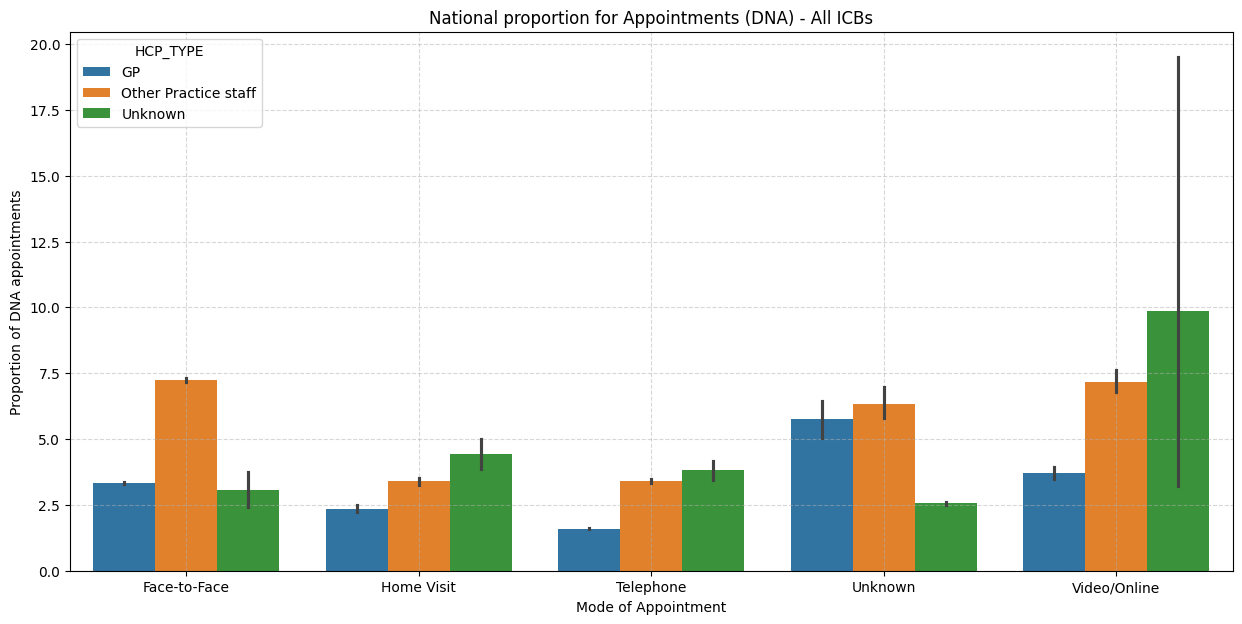

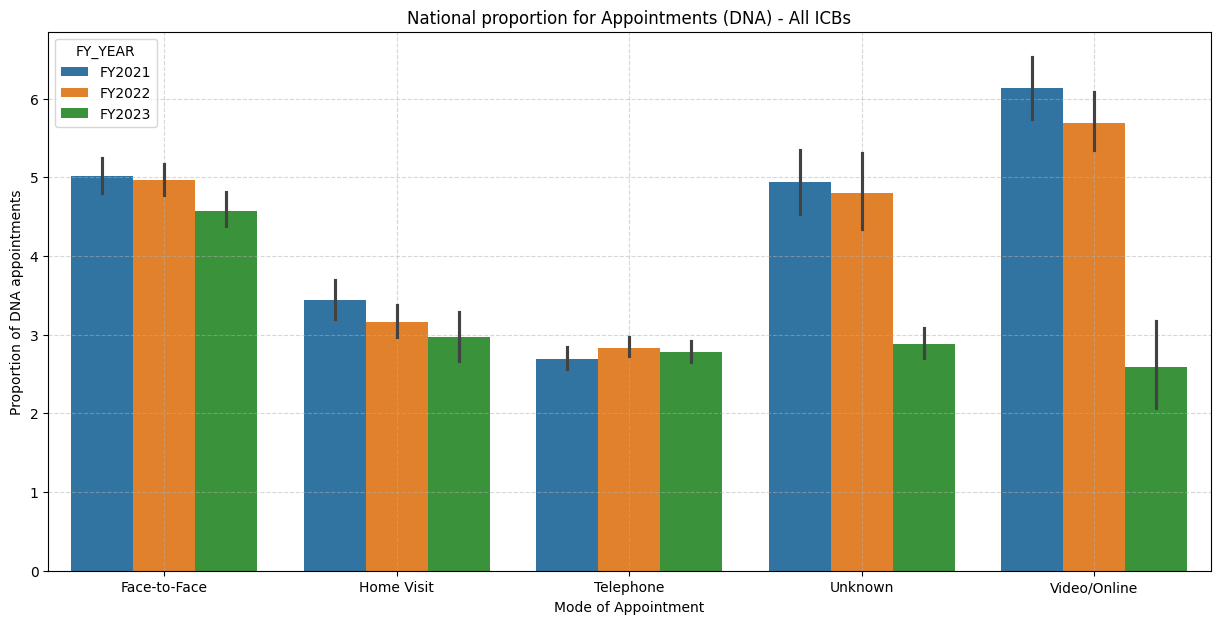

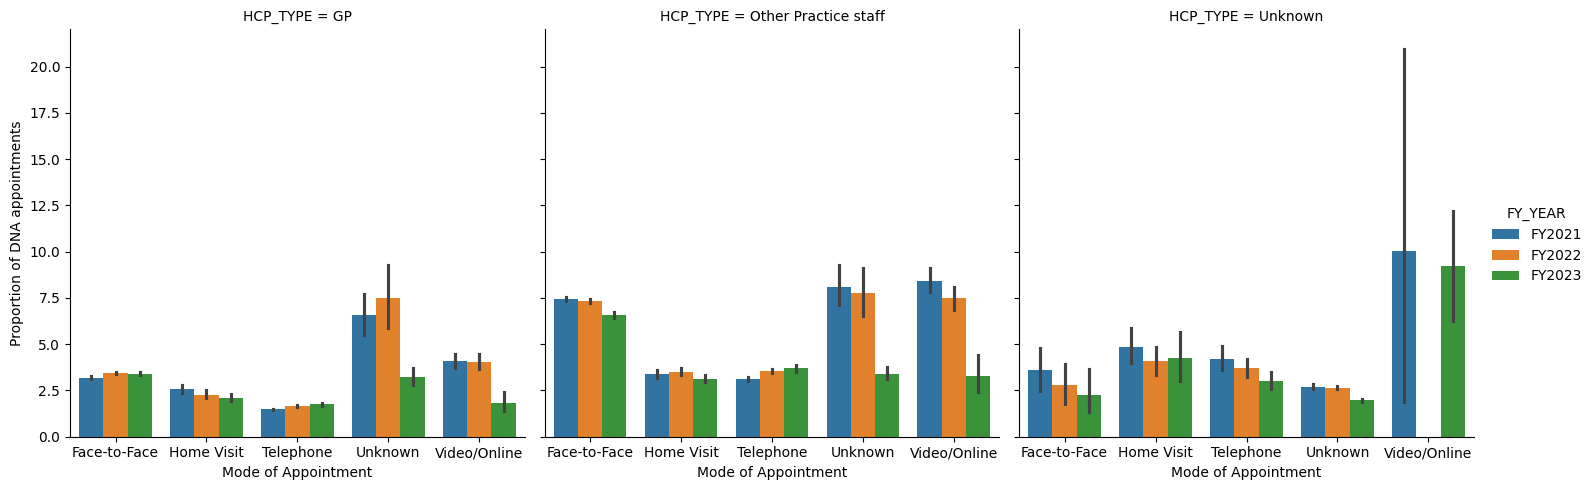

In [33]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='HCP_TYPE' , kind='bar', data=appt_proportion_df_plots)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

### **Correlation matrix all sub-icb's**

In [34]:
# Select categorical columns
categorical_columns = ['ICB_NAME','HCP_TYPE', 'APPT_MODE']

# Convert categorical columns to one-hot encoded features
one_hot_encoded = pd.get_dummies(appt_proportion_df_plots[categorical_columns])

dna_correlations_all_sub_icbs = one_hot_encoded.corrwith(appt_proportion_df_plots['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.171726
ICB_NAME_NHS Birmingham and Solihull Integrated Care Board                                0.136402
APPT_MODE_Face-to-Face                                                                    0.091964
APPT_MODE_Video/Online                                                                    0.089599
ICB_NAME_NHS Black Country Integrated Care Board                                          0.047746
ICB_NAME_NHS Suffolk and North East Essex Integrated Care Board                           0.041489
ICB_NAME_NHS Greater Manchester Integrated Care Board                                     0.040554
APPT_MODE_Unknown                                                                         0.026096
ICB_NAME_NHS South East London Integrated Care Board                                      0.017828
ICB_NAME_NHS North East and North Cumbria Integrated Care Board                           0.017768
ICB_NAME_N

### **SNEE sub-icb Analysis**

In [35]:
snee_appt_proportion_df = appt_proportion_df_plots.loc[appt_proportion_df_plots['SUB_ICB_LOCATION_CODE'].isin(snee_sub_icb)]
snee_appt_proportion_df = snee_appt_proportion_df.drop(columns=['ICB_NAME','APPOINTMENT_MONTH']).groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','FY_YEAR']).mean()
snee_appt_proportion_df

Attended       DNA  \
SUB_ICB_LOCATION_CODE HCP_TYPE APPT_MODE    FY_YEAR                         
06L                   GP       Face-to-Face FY2021    96.160833  1.320000   
                                            FY2022    95.175000  1.620833   
                                            FY2023    93.960000  1.598000   
                               Home Visit   FY2021    95.220833  2.360000   
                                            FY2022    94.628333  2.084167   
...                                                         ...       ...   
07K                   Unknown  Telephone    FY2022   100.000000       NaN   
                                            FY2023          NaN       NaN   
                               Unknown      FY2021    96.150000  1.402500   
                                            FY2022    94.431667  1.933333   
                                            FY2023    93.460000  1.486000   

                                                        Unknown  
SUB_ICB_LOCATION_CODE HCP_TYPE APPT_MODE    FY_YEAR              
06L                   GP       Face-to-Face FY2021     2.519167  
                                            FY2022     3.205000  
                                            FY2023     4.446000  
                               Home Visit   FY2021     2.418333  
                                            FY2022     3.288333  
...                                                         ...  
07K                   Unknown  Telephone    FY2022          NaN  
                                            FY2023   100.000000  
                               Unknown      FY2021     2.448333  
                                            FY2022     3.632500  
                                            FY2023     5.054000  

[111 rows x 3 columns]

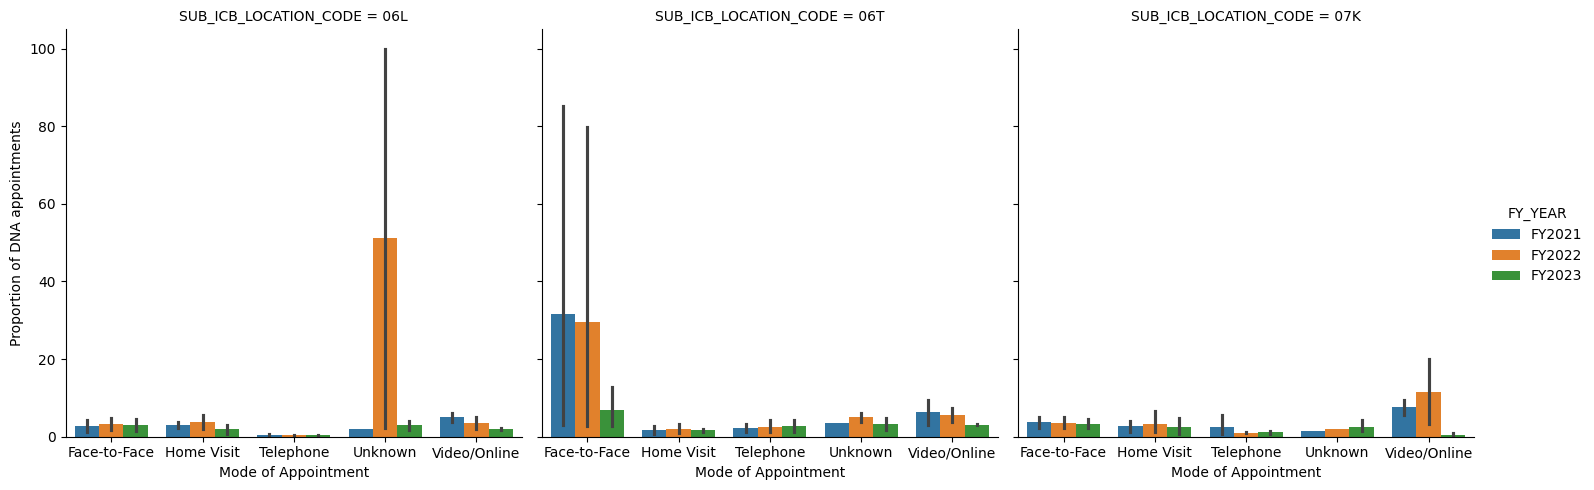

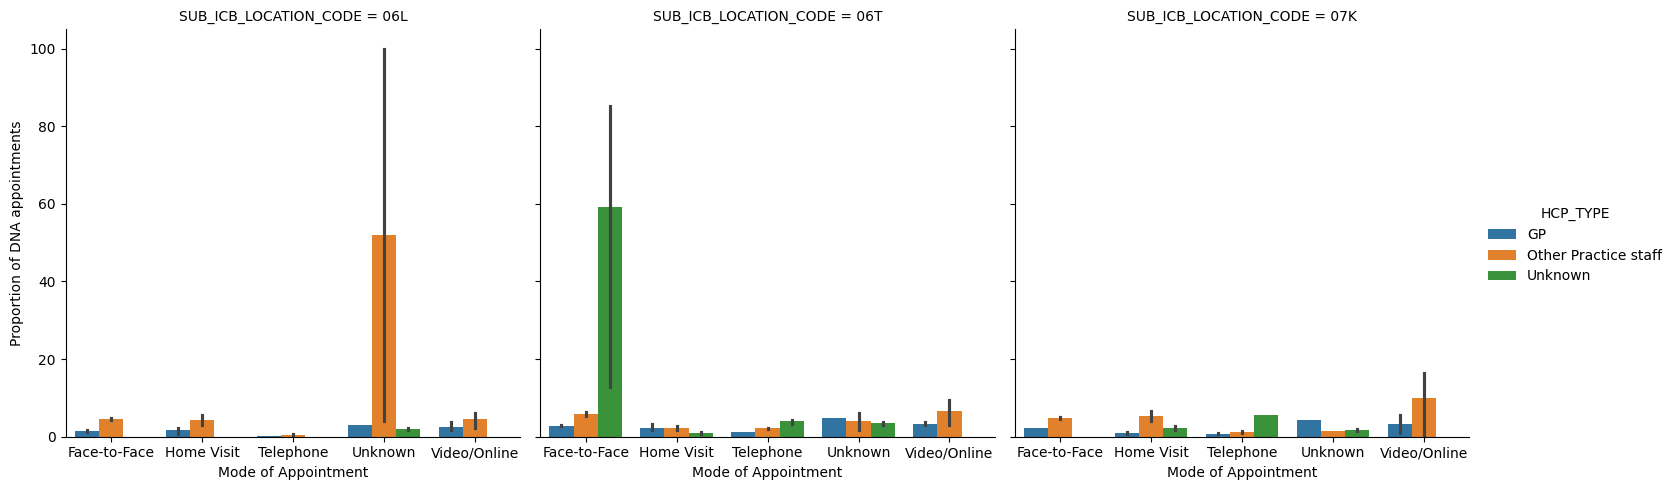

In [36]:
# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

In [37]:
snee_appt_proportion_df = snee_appt_proportion_df.reset_index()

### **Correlation matrix SNEE sub-icb's**

In [38]:
snee_appt_proportion_df

,SUB_ICB_LOCATION_CODE,HCP_TYPE,APPT_MODE,FY_YEAR,Attended,DNA,Unknown
0,06L,GP,Face-to-Face,FY2021,96.160833,1.320000,2.519167
1,06L,GP,Face-to-Face,FY2022,95.175000,1.620833,3.205000
2,06L,GP,Face-to-Face,FY2023,93.960000,1.598000,4.446000
3,06L,GP,Home Visit,FY2021,95.220833,2.360000,2.418333
4,06L,GP,Home Visit,FY2022,94.628333,2.084167,3.288333
...,...,...,...,...,...,...,...
106,07K,Unknown,Telephone,FY2022,100.000000,NaN,NaN
107,07K,Unknown,Telephone,FY2023,NaN,NaN,100.000000
108,07K,Unknown,Unknown,FY2021,96.150000,1.402500,2.448333
109,07K,Unknown,Unknown,FY2022,94.431667,1.933333,3.632500


In [39]:
cols = ['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']

# Convert categorical columns to one-hot encoded features
ce_OHE = pd.get_dummies(snee_appt_proportion_df[cols])

dna_correlations_snee_icbs = ce_OHE.corrwith(snee_appt_proportion_df['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face           0.204919
HCP_TYPE_Unknown                 0.165292
SUB_ICB_LOCATION_CODE_06T        0.101825
APPT_MODE_Unknown                0.091138
HCP_TYPE_Other Practice staff    0.050375
SUB_ICB_LOCATION_CODE_06L        0.004799
APPT_MODE_Video/Online          -0.019436
SUB_ICB_LOCATION_CODE_07K       -0.110447
APPT_MODE_Home Visit            -0.119116
APPT_MODE_Telephone             -0.143173
HCP_TYPE_GP                     -0.190721
dtype: float64


## **Inferences and Results**

### 1. Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

In [40]:
print(f'{National_average_dna_2021.item()} is the National average for DNA appointments(FY-2021)')
print(f'{National_average_dna_2022.item()} is the National average for DNA appointments(FY-2022)')
print(f'{National_average_dna_2023_april_august.item()} is the National average for DNA appointments(FY-2023, april-august)')

SNEE_average_DNA

27252.8 is the National average for DNA appointments(FY-2021)
31568.7 is the National average for DNA appointments(FY-2022)
29004.74 is the National average for DNA appointments(FY-2023, april-august)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,16323.2
FY2022,17822.6
FY2023,14968.0


- We can see that the each year's average for non-attended appointments for SNEE-ICB is much lesser than National Average.
  
- For year 2022, this difference increases as the National average is 31,568.7, whereas for SNEE-ICB it is 17,822.6

### 2. Are the missed appointments proportion (%) consistent over time using multiple years?

- The missed appointments are consistent over years when appointment mode is Face to Face, home visit or telephonic
- The missed appointments are not consistent over years when appointment mode is UNknown or Video/ONline

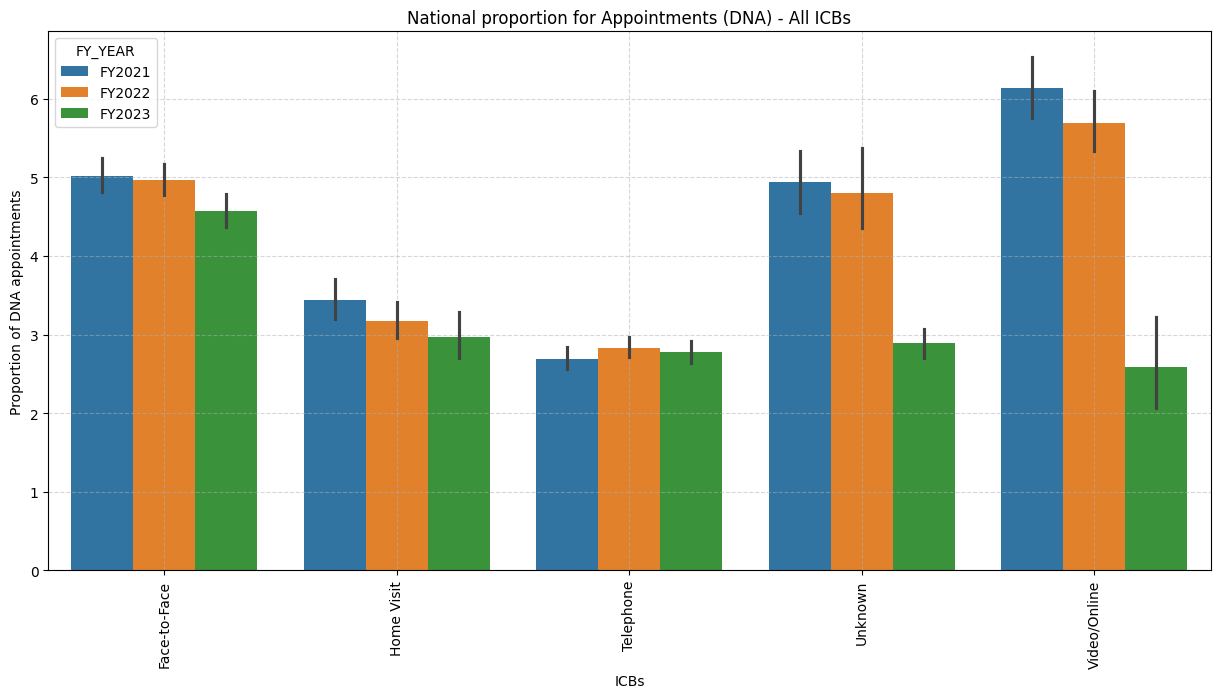

In [41]:
# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df_plots)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 3. Across staff groups & Sub-ICB, are some appointments more likely to be missed?


- Appointments that are with 'other practice staff' are most likely to be missed specially when mode of appointments is Face to Face, followed by UNknown

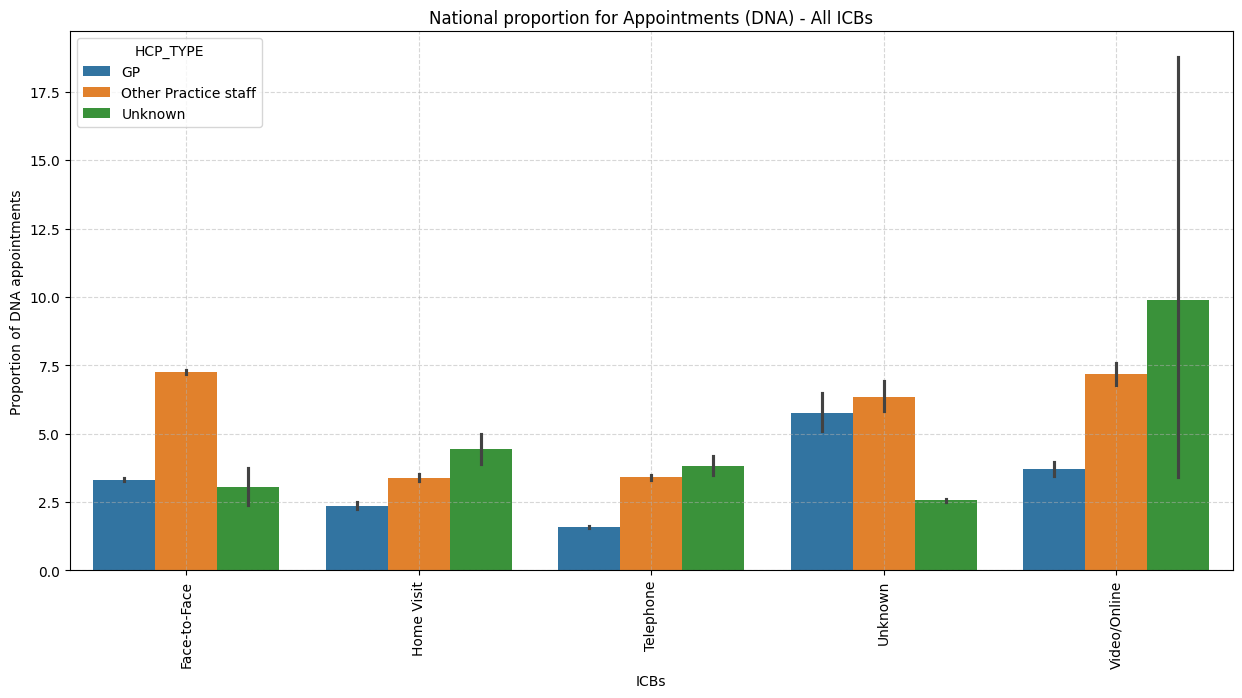

In [42]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df_plots)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 4. What is the mean likelihood that someone  Will not attend? from a combination of Sub-ICB, Staff type, Appointment type. 
5. to determine if a patient with the above appointment will attend.

#### 1. **For Snee ICB'S**

In [43]:
print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face           0.204919
HCP_TYPE_Unknown                 0.165292
SUB_ICB_LOCATION_CODE_06T        0.101825
APPT_MODE_Unknown                0.091138
HCP_TYPE_Other Practice staff    0.050375
SUB_ICB_LOCATION_CODE_06L        0.004799
APPT_MODE_Video/Online          -0.019436
SUB_ICB_LOCATION_CODE_07K       -0.110447
APPT_MODE_Home Visit            -0.119116
APPT_MODE_Telephone             -0.143173
HCP_TYPE_GP                     -0.190721
dtype: float64


- From the above Correlation matrix, we can infer the likelihood that a person in SNEE area will not attend (dna) appointment.
- Positive Correlation - if Appointment_MODE = 'Face-to-face' and HCP_TYPE = 'Unknown', then the person is most likely to **NOT ATTEND**
- Negative correlation - if HCP_TYPE = 'GP', then the person is most likely to **Attend**
- Interesting to note that if a person belongs to sub-icb North East Essex then its likely to not attend but the correlation is not very strong, so we cannot be very sure. Same goes for west suffolk but in a negative way (person is likely to attend) but again the correlation is not very strong

#### 2. **For all sub-icbs(102)**

In [44]:
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.171726
ICB_NAME_NHS Birmingham and Solihull Integrated Care Board                                0.136402
APPT_MODE_Face-to-Face                                                                    0.091964
APPT_MODE_Video/Online                                                                    0.089599
ICB_NAME_NHS Black Country Integrated Care Board                                          0.047746
ICB_NAME_NHS Suffolk and North East Essex Integrated Care Board                           0.041489
ICB_NAME_NHS Greater Manchester Integrated Care Board                                     0.040554
APPT_MODE_Unknown                                                                         0.026096
ICB_NAME_NHS South East London Integrated Care Board                                      0.017828
ICB_NAME_NHS North East and North Cumbria Integrated Care Board                           0.017768
ICB_NAME_N

- In all the sub-icb's we can infer from above correlations that if HCP-TYPE = (2 OR Other Practice staff), Then its most likely by someone to not attend the appointment

### 6. Persist the distribution information from 5. to a yaml file.

In [45]:
years_to_keep = ['FY2022', 'FY2023']

filtered_df = appt_proportion_df_plots[appt_proportion_df_plots['FY_YEAR'].isin(years_to_keep)]

filtered_df = filtered_df.drop(columns=['ICB_NAME','APPOINTMENT_MONTH','FY_YEAR','Unknown','Attended']).groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']).mean().round(2)
filtered_df = filtered_df.fillna(filtered_df.mean()).div(100).round(4)
filtered_df

DNA
SUB_ICB_LOCATION_CODE HCP_TYPE             APPT_MODE           
00L                   GP                   Face-to-Face  0.0219
                                           Home Visit    0.0203
                                           Telephone     0.0080
                                           Unknown       0.0087
                                           Video/Online  0.0307
...                                                         ...
X2C4Y                 Other Practice staff Telephone     0.0101
                                           Unknown       0.0452
                                           Video/Online  0.0565
                      Unknown              Face-to-Face  0.0397
                                           Unknown       0.0270

[1451 rows x 1 columns]

In [46]:
# Converting to Dictionary
dna_proportion_dict = filtered_df.squeeze().to_dict()

In [47]:
# To get the desired format in dictionary - {"ICB_code":  {"GP" {"In person" : 0.04 , "Online": 0.02, "Telephone", . . .}, . . .}, . . .}
nested_dna_proportion_dict = {}

for key, value in dna_proportion_dict.items():
    sub_icb_code, hcp_type, appt_mode = key
    if sub_icb_code not in nested_dna_proportion_dict:
        nested_dna_proportion_dict[sub_icb_code] = {}
    if hcp_type not in nested_dna_proportion_dict[sub_icb_code]:
        nested_dna_proportion_dict[sub_icb_code][hcp_type] = {}
    nested_dna_proportion_dict[sub_icb_code][hcp_type][appt_mode] = value
    
nested_dna_proportion_dict

{'00L': {'GP': {'Face-to-Face': 0.0219,
   'Home Visit': 0.0203,
   'Telephone': 0.008,
   'Unknown': 0.0087,
   'Video/Online': 0.0307},
  'Other Practice staff': {'Face-to-Face': 0.0641,
   'Home Visit': 0.0068,
   'Telephone': 0.0229,
   'Unknown': 0.0181,
   'Video/Online': 0.0581},
  'Unknown': {'Face-to-Face': 0.0059,
   'Home Visit': 0.0063,
   'Telephone': 0.1429,
   'Unknown': 0.0261}},
 '00N': {'GP': {'Face-to-Face': 0.0319,
   'Home Visit': 0.0746,
   'Telephone': 0.021,
   'Unknown': 0.0397,
   'Video/Online': 0.0397},
  'Other Practice staff': {'Face-to-Face': 0.0644,
   'Home Visit': 0.0293,
   'Telephone': 0.0477,
   'Unknown': 0.0397,
   'Video/Online': 0.0028},
  'Unknown': {'Face-to-Face': 0.0012,
   'Home Visit': 0.02,
   'Telephone': 0.0291}},
 '00P': {'GP': {'Face-to-Face': 0.0428,
   'Home Visit': 0.0142,
   'Telephone': 0.0199,
   'Unknown': 0.013,
   'Video/Online': 0.0006},
  'Other Practice staff': {'Face-to-Face': 0.0758,
   'Home Visit': 0.0145,
   'Telephon

In [48]:
OUTPUT_YAML_FILE = "outputs/assumptions/dna_appointments.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(dna_proportion_dict, yaml_file)